<a href="https://colab.research.google.com/github/YunHoLeee/FourPanelCartoon/blob/main/MRIK_Keyword_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한국어 형태소 분석기 활용과 키워드 추출

In [ ]:
# # 나눔고딕
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

!pip install -q kiwipiepy flashtext wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from kiwipiepy import Kiwi
kiwi = Kiwi()

from tqdm.notebook import tqdm
tqdm.pandas()

import itertools
from collections import Counter

import regex #확장된 정규표현식. 일반 정규표현식은 import re

from flashtext import KeywordProcessor
kp = KeywordProcessor()
from wordcloud import WordCloud

# import matplotlib.pyplot as plt


Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


<Figure size 500x500 with 0 Axes>

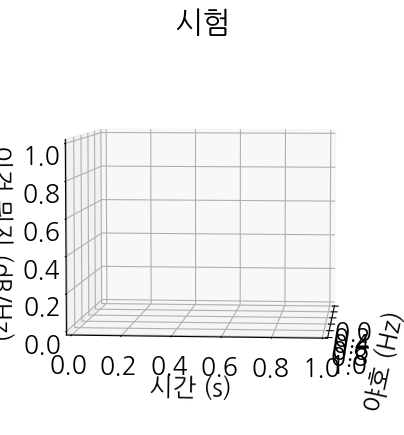

In [ ]:
# 시각화 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

# 테스트 해보기
fig = plt.figure(figsize=(5, 5))
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(5, 5))

graph_title = '시험'
ax.set_title(f'{graph_title}')
ax.set_xlabel('야호 (Hz)', labelpad=10)
ax.set_ylabel('시간 (s)', labelpad=10)
ax.set_zlabel('이건 뭐지 (dB/Hz)', labelpad=10)

ax.view_init(5, 5)
plt.show()

In [ ]:
# 이인직 소설 자료 다운로드
!wget --no-check-certificate 'https://docs.google.com/spreadsheets/d/16OcnCtUPvVImDCHtzYQUSdJ4_UHxeUVwKBCO5j2jLI8/edit?gid=0#gid=0' -O webtoon.xlsx

--2024-06-15 10:01:31--  https://docs.google.com/spreadsheets/d/16OcnCtUPvVImDCHtzYQUSdJ4_UHxeUVwKBCO5j2jLI8/edit?gid=0
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.102, 74.125.142.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘webtoon.xlsx’

webtoon.xlsx            [ <=>                ] 804.03K  4.47MB/s    in 0.2s    

2024-06-15 10:01:32 (4.47 MB/s) - ‘webtoon.xlsx’ saved [823329]



In [ ]:
df = pd.read_excel('/content/웹툰연구사 정리 데이터 최종(~2023) (2).xlsx')
df

,논문명,논문 ID,저자명,주저자 소속기관,학술지 ID,학술지명,저자키워드,초록,발행기관 ID,발행기관명,발행연도,대분류,중분류,종분류,URL,KCI 등재 구분
0,디지털 플랫폼 기업 M&A 전략의 경제․사회적 효과 분석: 카카오엔터테인먼트의 사례...,ART002937137,유병준;정연승;이정준;오예린,서울대학교,1117,Korea Business Review,"디지털 플랫폼, M&A, 디지털 콘텐츠, 카카오, 경제사회적 효과","본 연구는 카카오엔터테인먼트의 M&A 전략을 사례로 분석하여, 디지털 플랫폼 기업 ...",INS000000739,한국경영학회,2023,사회과학,경영학,경영교육,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
1,한국 웹툰 플랫폼의 섬네일 특징이 웹툰 선택에 미치는 영향: 이미지 분석을 적용하여,ART002995105,유승희;김호림;최진욱,이화여자대학교,1599,상품학연구,"웹툰, 섬네일, 이미지 분석, 콘텐츠, 한류",최근 한국의 웹툰은 원천 지식재산이자 한류 콘텐츠로서 급부상하며 산업적 가치가 높아...,INS000000807,한국상품학회,2023,사회과학,경영학,경영학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
2,창세신화를 활용한 문화적 리터러시 교육 방안 연구,ART002950050,변숙자,한국교원대학교,1465,청람어문교육,"문화적 리터러시, 문화교육, 고전문학, 창세신화, <천지왕본풀이>",본고는 고전문학 텍스트를 활용한 문화적 리터러시 교육의 실현 방안을 탐색하는 데 목...,INS000000267,청람어문교육학회,2023,인문학,문학,국어교육,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
3,만화에서 무배경이 유발하는 참여적 사유에 관한 담론,ART002950245,이용수,호서대학교,SER000000642,일러스트레이션 포럼,"만화/웹툰, 무배경, 참여적 사유","본고는 만화/웹툰 이미지를 분석하는 데에 있어서, 배경이 묘사되어 있는가 없는가 하...",INS000000241,한국일러스트레이션학회,2023,예술체육학,디자인,디자인,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
4,웹툰 이용에 따른 행위중독성 연구,ART003018786,박미라,성결대학교,2029,신학과 실천,"웹툰, 행위중독, 스마트폰 과의존, 이용동기, 감각추구",본 연구에서는 코로나19이후 증가된 웹툰 이용에 있어서 과의존 및 중독적 경향에 관...,INS000001585,한국실천신학회,2023,인문학,기독교신학,기독교신학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,인터넷 언어 문화 교육 내용으로서 디지털 서사의 개념 특성 유형에 관한 연구,ART001227261,정현선,경인교육대학교,1205,국어교육학연구,"인터넷, 기호, 소통, 디지털 서사, 인터넷 소설, 팬픽, 웹툰, 하이퍼텍스트 서사...",인터넷 언어 문화 교육 내용으로서디지털 서사의 개념특성유형에 관한 연구정현선본고는 ...,INS000001358,국어교육학회,2007,인문학,한국어와문학,한국어와문학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
666,웹 만화 <위대한 캣츠비>의 스토리텔링 구조 분석,ART001061496,이상민,가톨릭대학교,1717,대중서사연구,"위대한 캣츠비, 웹 만화, 스토리텔링, 웹 미디어의 특징, 서사적 층위","웹 만화 위대한 캣츠비는 웹의 매체를 이용한 서정성 획득, 3중 구조에 따른 서사적...",INS000000103,대중서사학회,2007,복합학,학제간연구,학제간연구,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재후보
667,디지털 컨텐츠 산업과 디지털 만화에 관한 연구,ART001039099,고은나,부천대학,SER000000642,일러스트레이션 포럼,NaN,디지털 기술의 발전은 사회문화 전반에 큰 파장을 일으키며 디지털 컨텐츠 산업을 빠른...,INS000000241,한국일러스트레이션학회,2006,예술체육학,디자인,디자인,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재후보
668,디지털 만화 콘텐츠 메타데이터 요소개발 및 적용,ART001203563,오상훈;조현주;이용배;강지훈;맹성현,명지대학교,D00564,정보처리학회논문지D,"메타데이터요소(Metadata Element), 디지털콘텐츠 유통기술(DRM), 디...","디지털콘텐츠 서비스 유형이 다양해지면서 콘텐츠 유통에 참여하는 주체들(저작자, 가공...",INS000000930,한국정보처리학회,2004,공학,정보 없음,공학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재


In [ ]:
# Import necessary libraries
import pandas as pd
from collections import Counter

# Load the newly uploaded Excel file
file_path_new = '/content/웹툰연구사 정리 데이터 최종(~2023) (2).xlsx'
df_new = pd.read_excel(file_path_new, sheet_name='서지정보')

# Remove spaces from keywords in '저자키워드' column
df_new['저자키워드'] = df_new['저자키워드'].str.replace(' ', '')

# Define the list of stopwords to remove from '저자키워드'
additional_stopwords = set([
    '웹툰', '웹만화', '디지털만화', '웹코믹스', '인터넷만화', '온라인만화', 'webtoon', '만화', 'Webtoon'
])

# Function to preprocess '저자키워드' and remove stopwords
def preprocess_keywords(keywords):
    if isinstance(keywords, str):
        keywords = keywords.split(',')
        keywords = [kw for kw in keywords if kw not in additional_stopwords]
        return ' '.join(keywords)
    return ''

# Apply the function to the '저자키워드' column
df_new['processed_keywords'] = df_new['저자키워드'].apply(preprocess_keywords)

# Tokenize the processed keywords to count frequencies
all_keywords = ' '.join(df_new['processed_keywords']).split()
keyword_counts = Counter(all_keywords)

# Get the top 30 keywords by frequency
top_30_keywords = keyword_counts.most_common(30)

# Convert to DataFrame for better readability
top_30_keywords_df = pd.DataFrame(top_30_keywords, columns=['Keyword', 'Frequency'])

# Display the DataFrame
top_30_keywords_df


,Keyword,Frequency
0,스토리텔링,35
1,문화콘텐츠,19
2,콘텐츠,16
3,신과함께,16
4,재매개,15
5,브랜드웹툰,15
6,트랜스미디어스토리텔링,14
7,웹소설,13
8,트랜스미디어,12
9,매체전환,12


In [ ]:
# 패키지 설치
!pip install -U tomotopy gdown -q

# Import necessary libraries
import pandas as pd
from collections import Counter
import tomotopy as tp

In [ ]:
# 패키지 설치
!pip install -U tomotopy gdown -q

# Import necessary libraries
import pandas as pd
from collections import Counter
import tomotopy as tp

# Load the newly uploaded Excel file
file_path_new = '/content/웹툰연구사 정리 데이터 최종(~2023) (2).xlsx'
df_new = pd.read_excel(file_path_new, sheet_name='서지정보')

# Remove spaces from keywords in '저자키워드' column
df_new['저자키워드'] = df_new['저자키워드'].str.replace(' ', '')

# Define the list of stopwords to remove from '저자키워드'
additional_stopwords = set([
    '웹툰', '웹 만화', '웹만화', '디지털만화', '웹코믹스', '인터넷만화',
    '온라인만화', 'webtoon', '만화', 'Webtoon'
])

# Function to preprocess '저자키워드' and remove stopwords
def preprocess_keywords(keywords):
    if isinstance(keywords, str):
        keywords = keywords.split(',')
        keywords = [kw for kw in keywords if kw not in additional_stopwords]
        return ' '.join(keywords)
    return ''

# Apply the function to the '저자키워드' column
df_new['processed_keywords'] = df_new['저자키워드'].apply(preprocess_keywords)

# Tokenize the processed keywords to count frequencies
all_keywords = ' '.join(df_new['processed_keywords']).split()
keyword_counts = Counter(all_keywords)

# Get the top 30 keywords by frequency
top_30_keywords = keyword_counts.most_common(30)

# Convert to DataFrame for better readability
top_30_keywords_df = pd.DataFrame(top_30_keywords, columns=['Keyword', 'Frequency'])

# Display the DataFrame
print(top_30_keywords_df)

# Create a list of processed keywords for each document
documents = df_new['processed_keywords'].tolist()

# Initialize the LDA model
lda_model = tp.LDAModel(k=10, min_cf=5, min_df=3, rm_top=5)

# Add documents to the LDA model
for doc in documents:
    if doc:  # Ensure that the document is not empty
        lda_model.add_doc(doc.split())

# Train the LDA model
for i in range(0, 1000, 10):
    lda_model.train(10)
    print(f'Iteration: {i}\tLog-likelihood: {lda_model.ll_per_word}')

# Display the topics
for i in range(lda_model.k):
    print(f'Topic {i}:', lda_model.get_topic_words(i, top_n=10))


        Keyword  Frequency
0         스토리텔링         35
1         문화콘텐츠         19
2           콘텐츠         16
3          신과함께         16
4           재매개         15
5         브랜드웹툰         15
6   트랜스미디어스토리텔링         14
7           웹소설         13
8        트랜스미디어         12
9          매체전환         12
10          일상툰         12
11         OSMU         12
12          캐릭터         11
13        웹툰플랫폼          9
14          플랫폼          8
15           서사          7
16           공감          7
17         가상현실          7
18         웹툰작가          6
19          세계관          6
20         바리공주          6
21         웹툰산업          6
22           영화          6
23           미생          6
24       디지털콘텐츠          5
25  크로스미디어스토리텔링          5
26         웹콘텐츠          5
27        상호작용성          5
28        사용자경험          5
29         웹툰IP          5
Iteration: 0	Log-likelihood: -4.334846472522865
Iteration: 10	Log-likelihood: -4.0379940922682485
Iteration: 20	Log-likelihood: -4.140010988588134
Iteration: 30	Lo